# Описание проекта

Интернет-магазине, который продаёт по всему миру компьютерные игры, хочет выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) на 2016 год.

На основании этих данных надо сделать прогноз на 2017


# 1. Общая информация о данных

In [1]:
# Загрузка библиотек
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Импорт данных
df = pd.read_csv('games.csv', sep=',' , decimal='.')
df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [2]:
# Характеристики данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# Уникальные значения рейтинга ESRB
df['Rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: Rating, dtype: int64

In [8]:
# Уникальные значения оценки пользователей
df['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.3       2
0.7       2
2.3       2
0         1
9.7       1
Name: User_Score, Length: 96, dtype: int64

In [6]:
# Уникальные значения оценки критиков
df['Critic_Score'].value_counts()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: Critic_Score, Length: 82, dtype: int64


## Выводы
Для удобной работы с данными надо сделать следующие действия:
* Заменить названия столбцов (привести их к нижнему регистру);
* Преобразовать данные в столбце год в формат даты, чтобы работать именно как с датой, а не числом;
* Преобразовать данные в столбце "User_Score" их объекта в число, чтобы можно было корректно сортировать и сравнивать данные;
* Пропуски в данных хотелось бы заменить, но учитывая что это оценки и нет данных с которыми они достаточно сильно коррелируют, этого делать не стоит, потому что некорректное заполнение пропусков приведет к искажению данных. Причинами пропусков могло стать отсутствие интереса критиков и пользователей к определенной игре, а это в свою очередь привело к маленькому количеству отзывов, по которому нельзя достоверно судить об игре
* В столбце "User_Score" присутствует аббаббревиатура "tbd" - "To Be Determined" (будет определено), что означает отсутствие оценки и должно быть заменено на NaN перед переводом данных в число
* Для удобства оценки надо сделать еще один столбец с суммарными продажами по всему миру

# 2. Подготовка данных

In [9]:
# Приведение названий столбцов к нижнему регистру
df.columns = df.columns.str.lower()
# Преобразуем тип данных в году 
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y')
# Заменяем аббревиатуру и столбец к числу
df['user_score'] = df['user_score'].replace('tbd', np.nan).astype(float)
# Создаем суммирующий столбец по продажам
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16713 non-null  object        
 1   platform         16715 non-null  object        
 2   year_of_release  16446 non-null  datetime64[ns]
 3   genre            16713 non-null  object        
 4   na_sales         16715 non-null  float64       
 5   eu_sales         16715 non-null  float64       
 6   jp_sales         16715 non-null  float64       
 7   other_sales      16715 non-null  float64       
 8   critic_score     8137 non-null   float64       
 9   user_score       7590 non-null   float64       
 10  rating           9949 non-null   object        
 11  sum_sales        16715 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 1.5+ MB


## Выводы 
Данные подготовлены согласно плана из части 1.

# 3. Исследовательский анализ данных

### Анализ выпуска игр по годам

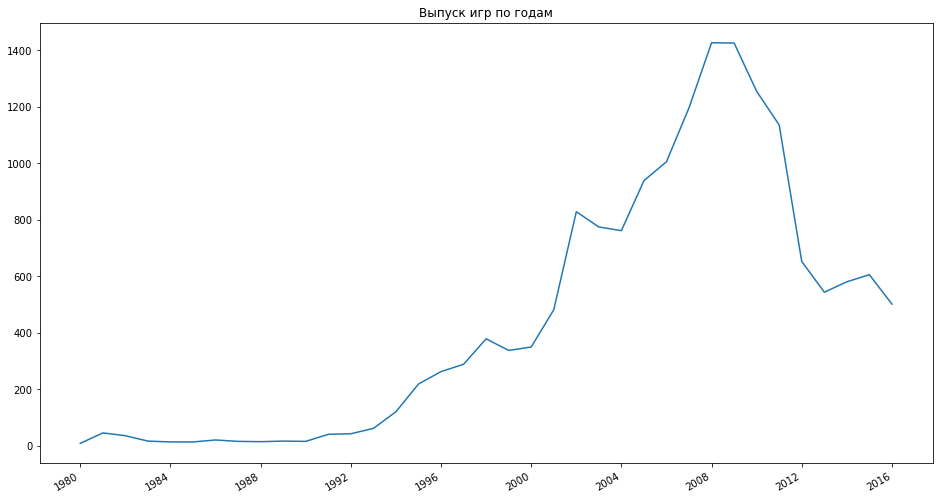

In [21]:
year_of_release = df['year_of_release'].value_counts()
year_of_release.plot(title = 'Выпуск игр по годам', figsize=(16,9))

Наибольшее количество игр выпущено в 2006-2011 годах, игр выпущенных ранее 1993 года мало

### Анализ выпуска игр по платформам

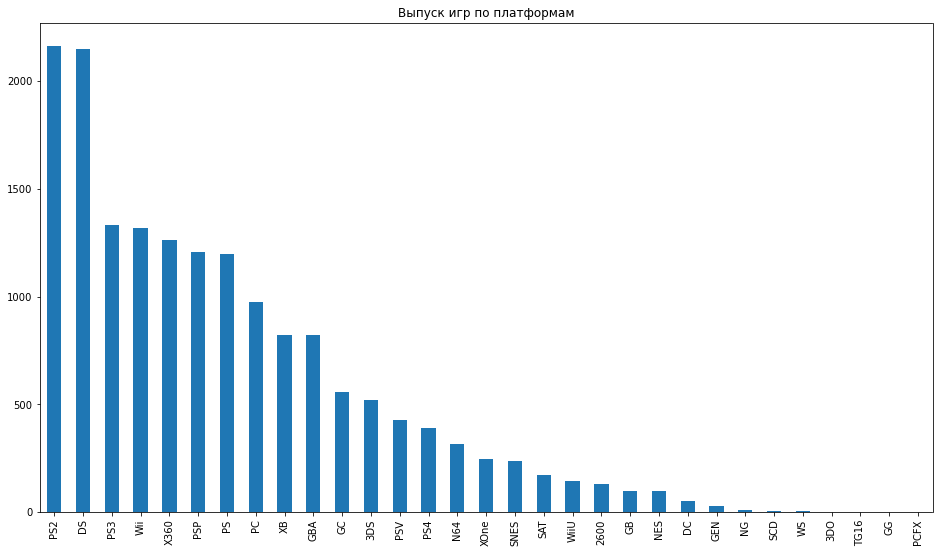

In [25]:
platform = df['platform'].value_counts()
platform.plot(kind = 'bar', title = 'Выпуск игр по платформам', figsize=(16,9))

In [28]:
#  Сводная таблица продаж по годам в разрезе платформ
platform_full = df.pivot_table(index='year_of_release',columns='platform',values='sum_sales',aggfunc=['sum'])
display(platform_full)

sum                                                         \
platform          2600   3DO    3DS    DC      DS     GB    GBA     GC    GEN   
year_of_release                                                                 
1980-01-01       11.38   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1981-01-01       35.68   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1982-01-01       28.88   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1983-01-01        5.84   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1984-01-01        0.27   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1985-01-01        0.45   NaN    NaN   NaN    0.02    NaN    NaN    NaN    NaN   
1986-01-01        0.67   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1987-01-01        1.94   NaN    NaN   NaN     NaN    NaN    NaN    NaN    NaN   
1988-01-01        0.74   NaN    NaN   NaN     NaN   1.43    NaN    NaN    NaN   
1989-01-01        0.63   NaN    NaN   NaN     NaN  64.97    NaN    NaN    NaN   
1990-01-01         NaN   NaN    NaN   NaN     NaN   4.89    NaN    NaN   2.60   
1991-01-01         NaN   NaN    NaN   NaN     NaN   5.57    NaN    NaN   4.33   
1992-01-01         NaN   NaN    NaN   NaN     NaN  25.49    NaN    NaN  12.64   
1993-01-01         NaN   NaN    NaN   NaN     NaN    NaN    NaN    NaN   3.07   
1994-01-01         NaN  0.02    NaN   NaN     NaN  12.18    NaN    NaN   8.13   
1995-01-01         NaN  0.08    NaN   NaN     NaN   3.60    NaN    NaN    NaN   
1996-01-01         NaN   NaN    NaN   NaN     NaN  36.03    NaN    NaN    NaN   
1997-01-01         NaN   NaN    NaN   NaN     NaN   6.37    NaN    NaN    NaN   
1998-01-01         NaN   NaN    NaN  3.38     NaN  26.90    NaN    NaN    NaN   
1999-01-01         NaN   NaN    NaN  5.16     NaN  38.00    NaN    NaN    NaN   
2000-01-01         NaN   NaN    NaN  5.99     NaN  19.76   0.07    NaN    NaN   
2001-01-01         NaN   NaN    NaN  1.07     NaN   9.24  61.53  26.34    NaN   
2002-01-01         NaN   NaN    NaN  0.29     NaN    NaN  74.16  51.81    NaN   
2003-01-01         NaN   NaN    NaN   NaN     NaN    NaN  56.67  50.61    NaN   
2004-01-01         NaN   NaN    NaN   NaN   17.27    NaN  77.91  28.82    NaN   
2005-01-01         NaN   NaN    NaN   NaN  130.14    NaN  33.86  27.62    NaN   
2006-01-01         NaN   NaN    NaN   NaN  119.81    NaN   5.28  11.26    NaN   
2007-01-01         NaN   NaN    NaN  0.02  146.94    NaN   3.40   0.27    NaN   
2008-01-01         NaN   NaN    NaN  0.04  145.31    NaN    NaN    NaN    NaN   
2009-01-01         NaN   NaN    NaN   NaN  119.54    NaN    NaN    NaN    NaN   
2010-01-01         NaN   NaN    NaN   NaN   85.02    NaN    NaN    NaN    NaN   
2011-01-01         NaN   NaN  63.20   NaN   26.18    NaN    NaN    NaN    NaN   
2012-01-01         NaN   NaN  51.36   NaN   11.01    NaN    NaN    NaN    NaN   
2013-01-01         NaN   NaN  56.57   NaN    1.54    NaN    NaN    NaN    NaN   
2014-01-01         NaN   NaN  43.76   NaN     NaN    NaN    NaN    NaN    NaN   
2015-01-01         NaN   NaN  27.78   NaN     NaN    NaN    NaN    NaN    NaN   
2016-01-01         NaN   NaN  15.14   NaN     NaN    NaN    NaN    NaN    NaN   

                       ...                                                 \
platform           GG  ...    SAT   SCD   SNES  TG16    WS     Wii   WiiU   
year_of_release        ...                                                  
1980-01-01        NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN    NaN   
1981-01-01        NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN    NaN   
1982-01-01        NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN    NaN   
1983-01-01        NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN    NaN   
1984-01-01        NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN    NaN   
1985-01-01        NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN    NaN   
1986-01-01        NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN    NaN   
1987-01-

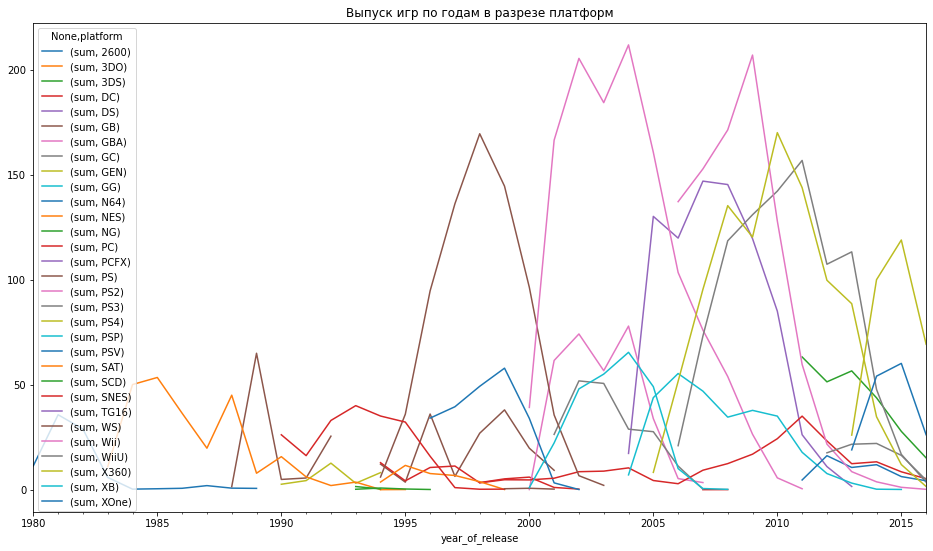

In [34]:
platform_full.plot(title = 'Выпуск игр по годам в разрезе платформ', figsize=(16,9))

Можно сказать, что в среднем продолжительность жизни платформы - порядка 10 лет. Есть долгожители, но в этом случае их продажи игр невелики. Определим какие платформы актуальны в 2016 годуи как они развивались за последние 10 лет

In [36]:
# Список платформ, на которых были продажи в 2016 году
platform_2016 = df.query('year_of_release == 2016 & sum_sales > 0')
platforms = platform_2016['platform'].value_counts().index.tolist()
print(platforms)

['PS4', 'XOne', 'PSV', 'PC', '3DS', 'PS3', 'WiiU', 'X360', 'Wii']


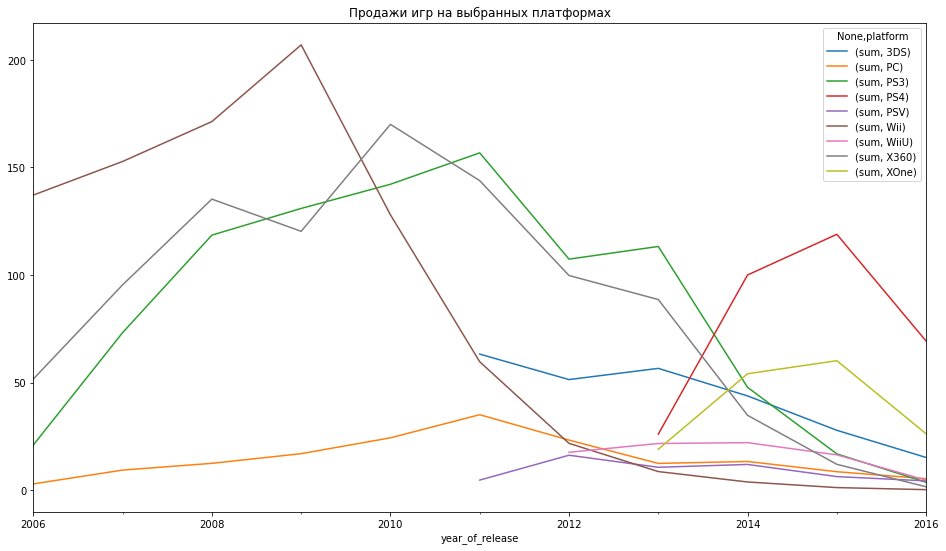

In [37]:
# Рисуем график выручки от игр на выбранных платформах
platform_select = df.query('platform in @platforms & year_of_release > 2005')
platform_select_sales = platform_select.pivot_table(index='year_of_release',columns='platform',values='sum_sales',aggfunc=['sum'])
platform_select_sales.plot(title = 'Продажи игр на выбранных платформах', figsize=(16,9))

На графике видно, что выручка падает на всех платформах. Возможно это связано с неполными данными за 2016 год. Если посмотреть на 2015год его тендеции, то мы можем выделить следующие перспективные платформы:
* PS4
* XOne
* 3DS
* PC
* WiiU

Платформы PS3 и X360 хоть ти имеют высокие продажи, но находятся в конце 10-летнего цикла и не являются перспективными


### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

Ограничим данные преспективными платформами и 2006 годом.

In [38]:
platform_perspective = ['PS4', 'XOne', '3DS', 'PC', 'WiiU']
platform_perspective_sales = df.query('platform in @platform_perspective & year_of_release > 2005')
platform_perspective_sales  = platform_perspective_sales.dropna()

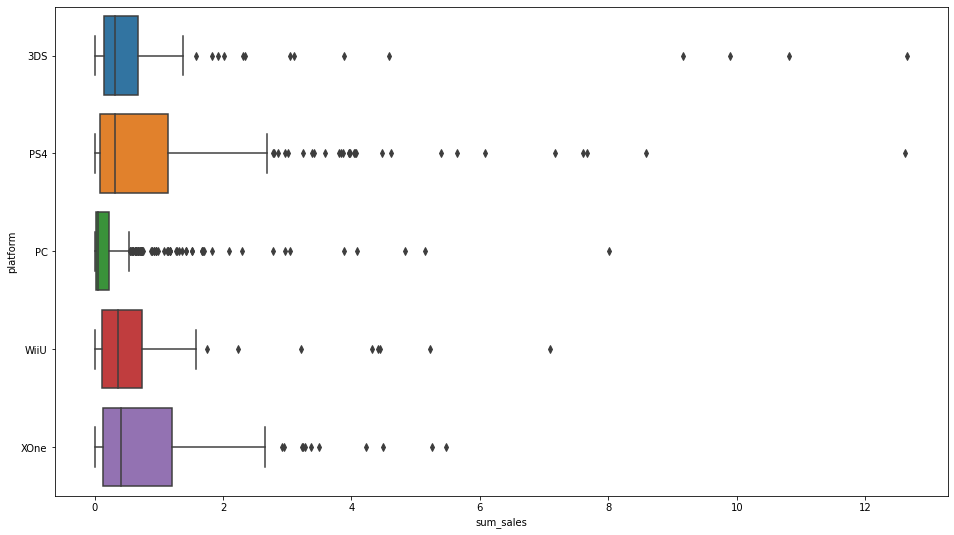

In [41]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(16,9))
sns.boxplot(y="platform", x="sum_sales", data=platform_perspective_sales, orient="h")

Наибольший разброс продаж у PS4, наименьший у PC

### Диграмма рассеяния и корреляция между отзывами и продажами внутри платформы PS4.

Коэффициент корреляции:  0.4065679020617814


<Figure size 432x288 with 0 Axes>

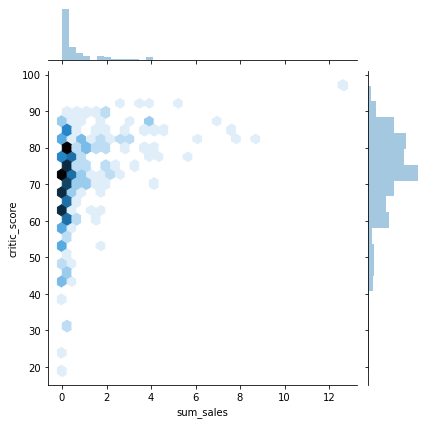

In [43]:
sales_PS4 = df.query("platform == 'PS4' & year_of_release > 2005")

sns.jointplot(x='sum_sales',y='critic_score',data=sales_PS4,kind='hex')
print('Коэффициент корреляции: ', sales_PS4['sum_sales'].corr(sales_PS4['critic_score']))

Зависимость продаж от оценок критиков есть, она положительная, но не явно выраженная

Коэффициент корреляции:  -0.031957110204556424


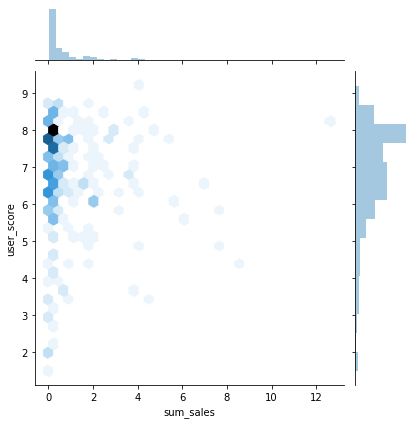

In [12]:
sales_PS4 = df.query("platform == 'PS4' & year_of_release > 2005")
sns.jointplot(x='sum_sales',y='user_score',data=sales_PS4,kind='hex')
print('Коэффициент корреляции: ', sales_PS4['sum_sales'].corr(sales_PS4['user_score']))

Зависимость продаж от оценок пользователей отсутствует

### Распределение игр по жанрам.

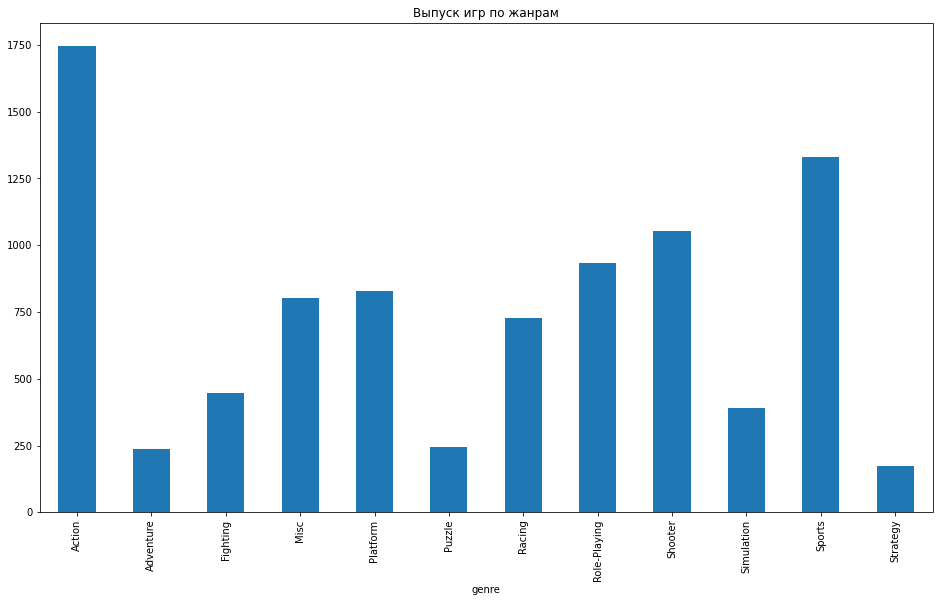

In [44]:
genres = df.groupby('genre')['sum_sales'].sum()
genres.plot(kind = 'bar', title = 'Выпуск игр по жанрам', figsize=(16,9))

Самыми прибыльными жанрами являются Action, Sports, Shooter, Role-Playing, Platform. Их отличие от Strtegy - в 10 раз, Adventure - в 5 раз. Большая разница     


## Выводы
1. Наибольшее количество игр выпущено в 2006-2011 годах, игр выпущенных ранее 1993 года мало
2. В среднем продолжительность жизни платформы - порядка 10 лет. Есть долгожители, но в этом случае их продажи игр невелики. С учетом этого актуальным периодом является 2006-2016 годы
3. К 2016 году наиболее перспективные платформы: PS4, XOne, 3DS, PC, WiiU. Платформы PS3 и X360 хоть ти имеют высокие продажи, но находятся в конце 10-летнего цикла и не являются перспективными
4. Наибольший разброс продаж у PS4, наименьший у PC
5. Зависимость продаж от оценок критиков есть, она положительная, но не явно выраженная
6. Зависимость продаж от оценок пользователей отсутствует

# 4. Портрет пользователя каждого региона

**Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5) с 2006 года.** 

In [45]:
df_2006 = df.query('year_of_release > 2005') # Данные с 2006 года
region = ['na', 'eu', 'jp'] # Префиксы регионов
# Функция для расчета ТОП-5 одной из храктеристик и их долей в продажах
def sales_and_shares(column):
    sales = df_2006.pivot_table(index = column, aggfunc = 'sum')[['eu_sales','jp_sales','na_sales']] # Сводная таблица продаж
    for col in sales.columns: # Добавление данных по долям на рынке
        sales[col[:2] + '_share'] = sales[col] / sales[col].sum()
    for r in region:
        print('ТОП-5 по продажам в ', r, 'и их доля продаж')
        print(sales.loc[:,[r+'_sales', r+'_share']].sort_values(by = r+'_sales', ascending = False).head().reset_index())
sales_and_shares('platform')       

ТОП-5 по продажам в  na и их доля продаж
  platform  na_sales  na_share
0     X360    588.84  0.246720
1      Wii    486.87  0.203996
2      PS3    390.13  0.163462
3       DS    323.99  0.135750
4      PS2    114.89  0.048138
ТОП-5 по продажам в  eu и их доля продаж
  platform  eu_sales  eu_share
0      PS3    327.21  0.218723
1     X360    267.89  0.179071
2      Wii    258.32  0.172674
3       DS    142.99  0.095582
4      PS4    141.09  0.094311
ТОП-5 по продажам в  jp и их доля продаж
  platform  jp_sales  jp_share
0       DS    141.49  0.252071
1      3DS    100.62  0.179259
2      PS3     79.41  0.141473
3      PSP     70.63  0.125831
4      Wii     68.28  0.121644


В разных регионах - разные платформы-фавориты. На ТОП-5 приходится доля 70-80 % рынка. PS3, Wii, DS присутствуют во всех трех рейтингах.

**Определим для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5) с 2006 года.**

In [15]:
sales_and_shares('genre')       

ТОП-5 по продажам в  na и их доля продаж
          genre  na_sales  na_share
0        Action    530.44  0.222251
1        Sports    396.64  0.166190
2       Shooter    373.13  0.156339
3          Misc    285.06  0.119438
4  Role-Playing    199.63  0.083644
ТОП-5 по продажам в  eu и их доля продаж
     genre  eu_sales  eu_share
0   Action    350.70  0.234425
1   Sports    251.55  0.168148
2  Shooter    238.89  0.159686
3     Misc    146.88  0.098182
4   Racing    113.39  0.075795
ТОП-5 по продажам в  jp и их доля продаж
          genre  jp_sales  jp_share
0  Role-Playing    170.38  0.303540
1        Action    102.07  0.181842
2          Misc     64.53  0.114963
3        Sports     48.97  0.087242
4      Platform     35.20  0.062710


В Европе и Америке сходны популярные жанры и За счет наибольших продаж они отражают общую картину, о которой говорилось выше. В Японии самым популярным жанром с большим отрывом является Role-Playing и это определяет его попадание в оверхние строчки общего рейтинга. И все равно его продажи в Японии меньше чем, в Америке, где он находится на 5 месте. 

**Определим влияет ли рейтинг ESRB на продажи в отдельном регионе?**

In [16]:
sales_and_shares('rating')       

ТОП-5 по продажам в  na и их доля продаж
  rating  na_sales  na_share
0      E    796.98  0.377328
1      M    574.33  0.271915
2      T    424.14  0.200808
3   E10+    315.40  0.149325
4     EC      1.32  0.000625
ТОП-5 по продажам в  eu и их доля продаж
  rating  eu_sales  eu_share
0      E    461.09  0.363404
1      M    398.90  0.314389
2      T    235.44  0.185560
3   E10+    173.35  0.136624
4     RP      0.03  0.000024
ТОП-5 по продажам в  jp и их доля продаж
  rating  jp_sales  jp_share
0      E    120.36  0.422880
1      T     83.90  0.294779
2      M     43.79  0.153854
3   E10+     36.57  0.128487
4     EC      0.00  0.000000


Рейтинг ESRB влияет достаточно сильно на продажи. Игры с рейтингом E, M, T, EC10+, EC - присутствуют в топе во всех регионах 

## Выводы
1. В разных регионах - разные платформы-фавориты. На ТОП-5 приходится доля 70-80 % рынка. PS3, Wii, DS присутствуют во всех трех рейтингах.
2. В Европе и Америке сходны популярные жанры и За счет наибольших продаж они отражают общую картину, о которой говорилось выше. В Японии самым популярным жанром с большим отрывом является Role-Playing и это определяет его попадание в оверхние строчки общего рейтинга. И все равно его продажи в Японии меньше чем, в Америке, где он находится на 5 месте. 
3. Рейтинг ESRB влияет достаточно сильно на продажи. Игры с рейтингом E, M, T, EC10+, EC - присутствуют в топе во всех регионах

# 5. Проверка гипотез

    Учитывая то, что мы удалили неопределенные значения в столбце 'user_score' мы имеем дело не с генеральной совокупностью, а просто с выборкой, но по ней мы можем судить о всей совокупности.
    При сопоставлении  двух выборок достаточно сопоставить их средние. 
    А после определения и сравнения p-value можно будет сделать вывод о достоверности гипотез.

## Гипотеза про средние пользовательские рейтинги
**Нулевая гипотеза.** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
**Альтернативная гипотеза** Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [17]:
alpha = 0.05 # критический уровень статистической значимости
# Создание рядов значчений пользовательских рейтингов
user_scores_xbox = df.query("platform == 'XOne'").loc[:,'user_score'].dropna() 
user_scores_pc = df.query("platform == 'PC'").loc[:,'user_score'].dropna() # 

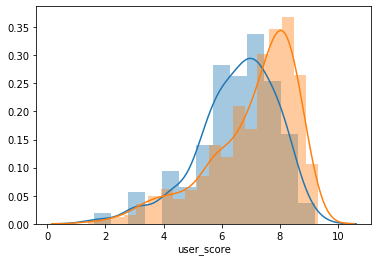

Средняя оценка Xbox:  6.521428571428572
Средняя оценка PC:  7.062467532467533


In [18]:
# Гистограмма распределения выручки по платформам
sns_plot = sns.distplot(user_scores_xbox)
fig = sns_plot.get_figure()
sns_plot = sns.distplot(user_scores_pc)
fig = sns_plot.get_figure()
plt.show()
print('Средняя оценка Xbox: ',user_scores_xbox.mean())
print('Средняя оценка PC: ',user_scores_pc.mean())

In [19]:
# Проверка гипотезы
results = st.ttest_ind(
    user_scores_xbox, 
    user_scores_pc)
print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.3896435533548819e-05
Отвергаем нулевую гипотезу


### Вывод.
    Нулевая гипотеза отвергается. Средние пользовательские рейтинги платформ Xbox One и PC разные. Это видно на графиках. Рейтинги на платформе PC выше.

## Гипотеза про средние пользовательские рейтинги
**Нулевая гипотеза.** Средние пользовательские рейтинги жанров Action и Sport одинаковые.  
**Альтернативная гипотеза** редние пользовательские рейтинги жанров Action и Sport разные.

In [20]:
# Создание рядов значчений пользовательских рейтингов
user_scores_action = df.query("genre == 'Action'").loc[:,'user_score'].dropna()
user_scores_sports = df.query("genre == 'Sports'").loc[:,'user_score'].dropna()

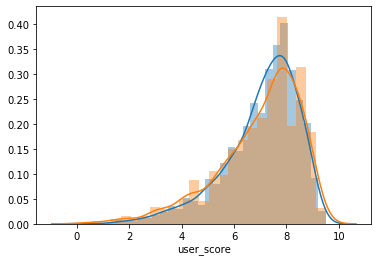

Средняя оценка Action:  7.054043715846995
Средняя оценка Sports:  6.961196736174069


In [21]:
# Гистограмма распределения выручки по платформам
sns_plot = sns.distplot(user_scores_action)
fig = sns_plot.get_figure()
sns_plot = sns.distplot(user_scores_sports)
fig = sns_plot.get_figure()
plt.show()
print('Средняя оценка Action: ',user_scores_action.mean())
print('Средняя оценка Sports: ',user_scores_sports.mean())

In [22]:
# Проверка гипотезы
results = st.ttest_ind(
    user_scores_action, 
    user_scores_sports)
print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.10406951359049141
Не получилось отвергнуть нулевую гипотезу


### Вывод.
    Нулевая гипотеза подтверждается. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

# Общий вывод

<b>При сохранении текущих тендеций наиболее перспективными продуктами в ближайшм будующим будут:
1. Игры сделанные на платформах: PS4, XOne, 3DS, PC, WiiU. Платформы PS3 и X360 хоть ти имеют высокие продажи, но находятся в конце 10-летнего цикла и не являются перспективными
2. Самыми прибыльными жанрами являются Action, Sports, Shooter, Role-Playing, Platform. Их отличие от Strtegy - в 10 раз, Adventure - в 5 раз. Большая разница
3. В разных регионах - разные платформы-фавориты. На ТОП-5 приходится доля 70-80 % рынка. PS3, Wii, DS присутствуют во всех трех рейтингах.
4. В Европе и Америке сходны популярные жанры и За счет наибольших продаж они отражают общую картину, о которой говорилось выше. В Японии самым популярным жанром с большим отрывом является Role-Playing и это определяет его попадание в оверхние строчки общего рейтинга. И все равно его продажи в Японии меньше чем, в Америке, где он находится на 5 месте.
5. Рейтинг ESRB влияет достаточно сильно на продажи. Игры с рейтингом E, M, T, EC10+, EC - присутствуют в топе во всех регионах 
</b>    

В ходе работы было сделаны следующие действия и выводы:
1. Для удобной работы с данными проведены следующие действия:
    * Заменить названия столбцов (привести их к нижнему регистру);
    * Преобразовать данные в столбце год в формат даты, чтобы работать именно как с датой, а не числом;
    * Преобразовать данные в столбце "User_Score" их объекта в число, чтобы можно было корректно сортировать и сравнивать данные;
    * Пропуски в данных хотелось бы заменить, но учитывая что это оценки и нет данных с которыми они достаточно сильно коррелируют, этого делать не стоит, потому что некорректное заполнение пропусков приведет к искажению данных. Причинами пропусков могло стать отсутствие интереса критиков и пользователей к определенной игре, а это в свою очередь привело к маленькому количеству отзывов, по которому нельзя достоверно судить об игре
    * В столбце "User_Score" присутствует аббаббревиатура "tbd" - "To Be Determined" (будет определено), что означает отсутствие оценки и должно быть заменено на NaN перед переводом данных в число
    * Для удобства оценки надо сделать еще один столбец с суммарными продажами по всему миру

2. Наибольшее количество игр выпущено в 2006-2011 годах, игр выпущенных ранее 1993 года мало. Учитывая что продолжительность "жизненного цикла" платформ - 10 лет, за актуальный период можно принять *2006-2016 годы*.

3. Определили перспективные платформы как: PS4, XOne, 3DS, PC, WiiU.

4. Наибольший разброс продаж из перспективных платформ у PS4, наименьший у PC

5. Зависимость продаж от оценок критиков есть, она положительная, но не явно выраженная

6. Зависимость продаж от оценок пользователей отсутствует

7. Средние пользовательские рейтинги платформ Xbox One и PC разные. Это видно на графиках. Рейтинги на платформе PC выше.

8. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
